# Modeling
Goal: Build 2-3 models and determine the best one that effectively predicts the stated goal in the problem identification section. 

* What are the types of models that would be appropriate, given this modeling response/features?
* Consider different algorithm types in your model selection
* Consider applying model hyperparameter tuning operations.
* Define the metrics you use to choose your final model.

### My questions:
* What is my original goal/problem? (Where do dogs come from and where do they go? Which breeds are most popular in which states?)
* What are different models to try? How to figure out which are appropriate? 

### Steps:
* Fit your models with a training dataset.
    * Try different models. Compare outputs in the model evaluation stage. (i.e. for classification models, do both entropy model and a Gini impurity model. For hyperparameter tuning, use methods like cross-validation)
* Review model outcomes and iterate over additional models as needed.
    * Use standard model evaluation metrics like accuracy, recall, precision, F1
* Identify the best model for the project
    * The most powerful model isn't always the best one. Consider computational complexity, scalability, and maintenance costs.
 
### Guiding questions:
* Does my data involve a time series or forecasting? If so, am I splitting the train and test data appropriately?
* Is my response variable continuous or categorical?s

## 1.) Repeat code from previous step (Pre-processing and Training Data)

### 1a.) Import libraries and load data

In [291]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
pd.set_option("display.max_rows", 10)

In [293]:
# Load data
allDogs = pd.read_csv('clean2- allDogDescription.csv')
dogTravel = pd.read_csv('clean2- dogTravel.csv')
movesByLocation = pd.read_csv('clean2- movesByLocation.csv')

C:\Users\yenmi\AppData\Local\Temp\ipykernel_8568\2673621457.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  allDogs = pd.read_csv('clean2- allDogDescription.csv')


### 1b.) Create dummy variables

In [18]:
# Create function that returns list of categories to be one-hot encoded
def identify_dummy_categories(df, thresh=10):
    categories = []
    for col in df.columns:
        if df[col].nunique() < thresh:
            categories.append(col)
            print(col + " unique values: " + str(df[col].nunique()))
    return categories

In [19]:
identify_dummy_categories(allDogs)

breed_mixed unique values: 2
age unique values: 4
sex unique values: 3
size unique values: 4
coat unique values: 6
fixed unique values: 2
house_trained unique values: 2
special_needs unique values: 2
shots_current unique values: 2
env_children unique values: 2
env_dogs unique values: 2
contact_country unique values: 2
region unique values: 5


['breed_mixed',
 'age',
 'sex',
 'size',
 'coat',
 'fixed',
 'house_trained',
 'special_needs',
 'shots_current',
 'env_children',
 'env_dogs',
 'contact_country',
 'region']

In [453]:
features = ['breed_primary', 'breed_mixed', 'age', 'sex', 'size', 'coat', 'fixed', 'house_trained', 'special_needs', 'shots_current', 'env_children', 'env_dogs', 'contact_state']
allDogs = allDogs[features]

# One-hot encode these columns.
allDogs_encoded = pd.get_dummies(allDogs, columns=['age', 'sex', 'size', 'coat', 'contact_state'])

# Turn the 'breed_primary' into a multiclass categorical label
code_dict = {'Pit Bull Terrier': 0, 'Labrador Retriever': 1, 'Chihuahua': 2, 'Mixed Breed': 3, 'Terrier': 4, 
             'Hound': 5, 'German Shepherd Dog': 6, 'Boxer': 7, 'Shepherd': 8, 'American Staffordshire Terrier': 9}
allDogs_encoded['breed_code'] = allDogs_encoded['breed_primary'].map(code_dict)
allDogs_encoded['breed_code'] = allDogs_encoded['breed_code'].fillna(10)
allDogs_encoded.drop('breed_primary', inplace=True, axis=1)

In [22]:
identify_dummy_categories(dogTravel)

contact_region unique values: 4
found_region unique values: 5


['contact_region', 'found_region']

In [311]:
# Only one-hot encode the 'contact_region' column.
dogTravel_encoded = pd.get_dummies(dogTravel, columns=['contact_region'])

# Turn the 'found_region' into a multiclass categorical label
code_dict = {'International': 0, 'Midwest': 1, 'Northeast': 2, 'South': 3, 'West': 4}
dogTravel['found_code'] = dogTravel['found_region'].map(code_dict)

In [25]:
identify_dummy_categories(movesByLocation, 12)

region unique values: 11
inUS unique values: 2


['region', 'inUS']

In [43]:
movesByLocation_encoded = pd.get_dummies(movesByLocation, columns=identify_dummy_categories(movesByLocation, 12))

region unique values: 11
inUS unique values: 2


### 1c.) Standardize Values

In [297]:
scaler = StandardScaler()

In [299]:
movesByLocation_scaled = movesByLocation_encoded.copy()

In [301]:
features = ['exported', 'imported', 'total']
movesByLocation_scaled[features] = scaler.fit_transform(movesByLocation_scaled[features])

### 1d.) Split into test and training data [dogTravel]

In [313]:
dogTravel_encoded.head()

,id,contact_city,contact_state,description,found,found_region,found_code,contact_region_Midwest,contact_region_Northeast,contact_region_South,contact_region_West
0,44520267,Anoka,MN,Boris is a handsome mini schnauzer who made hi...,AR,South,3,True,False,False,False
1,44698509,Groveland,FL,Duke is an almost 2 year old Potcake from Abac...,Bahamas,International,0,False,False,True,False
2,45983838,Adamstown,MD,Zac Woof-ron is a heartthrob movie star lookin...,MD,South,3,False,False,True,False
3,44475904,Saint Cloud,MN,~~Came in to the shelter as a transfer from an...,MN,Midwest,1,True,False,False,False
4,43877389,Pueblo,CO,Palang is such a sweetheart. She loves her peo...,Afghanistan,International,0,False,False,False,True


In [315]:
# By using the 'dogTravel_encoded'
# We can predict to this questions: "Where might have this dog come from, given where it is now?"
features = ['contact_region_Midwest', 'contact_region_Northeast', 'contact_region_South', 'contact_region_West']
X = dogTravel_encoded[features]
y = dogTravel_encoded[['found_code']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [186]:
X_train.head()

,contact_region_Midwest,contact_region_Northeast,contact_region_South,contact_region_West
3584,False,True,False,False
1948,False,True,False,False
1132,False,False,True,False
1427,False,False,True,False
3783,True,False,False,False


In [317]:
print(X_train.columns)
print(y_train)
print("\nSize of the training data: " + str(X_train.shape))
print("Size of the testing data: " + str(X_test.shape))
print("y_train will train the answers for the X_train data set. Length: " + str(len(y_train)))
print("y_test will be used to check the accuracy of the predictions made from x_test. Length: " + str(len(y_test)))

Index(['contact_region_Midwest', 'contact_region_Northeast',
       'contact_region_South', 'contact_region_West'],
      dtype='object')
      found_code
3584           3
1948           3
1132           3
1427           3
3783           3
...          ...
3444           3
466            3
3092           3
3772           3
860            2

[2880 rows x 1 columns]

Size of the training data: (2880, 4)
Size of the testing data: (1235, 4)
y_train will train the answers for the X_train data set. Length: 2880
y_test will be used to check the accuracy of the predictions made from x_test. Length: 1235


**Notes**
* The training data has information like id, contact_city, contact_state, contact_region (dummy), description, and found_region (dummy).
* The test data is the found state.
* Size of the training data: (2880, 4)* 
Size of the testing data: (1235, 4)* 
y_train will train the answers for the X_train data set. Length: 288* 0
y_test will be used to check the accuracy of the predictions made from x_test. Length: 1235235

**Changes**
* I think I should use the one-hot encoded 'region' for training to try to predict the found region.

## 2.) Modeling and Evaluating [dogTravel]

In [319]:
y_train.head()

,found_code
3584,3
1948,3
1132,3
1427,3
3783,3


In [373]:
def evaluateModel(model, y_pred):
    accuracy = accuracy_score(y_test, y_pred) # percentage of y_pred that matches y_test
    precision = precision_score(y_test, y_pred, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
    recall = recall_score(y_test, y_pred, average='micro', zero_division=np.nan)
    f1 = f1_score(y_test, y_pred, average='micro', zero_division=np.nan)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), average='micro', multi_class='ovr')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    print(f"Confusion Matrix:\n{cm}")
    
    # Plot the confusion matrix
    sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title('Confusion Matrix',fontsize=16)
    plt.show()
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y['found_code'], cv=5) # 5-fold cross-validation
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean cross-validation score: {cv_scores.mean()}")

Accuracy: 0.7044534412955465
Precision: 0.7044534412955465
Recall: 0.7044534412955465
F1-score: 0.7044534412955465
ROC-AUC: 0.9203840416987658
Confusion Matrix:
[[  0   4   0 112  34]
 [  0  99   0   6   1]
 [  0   1   0  76   0]
 [  0  60   0 687  64]
 [  0   1   0   6  84]]


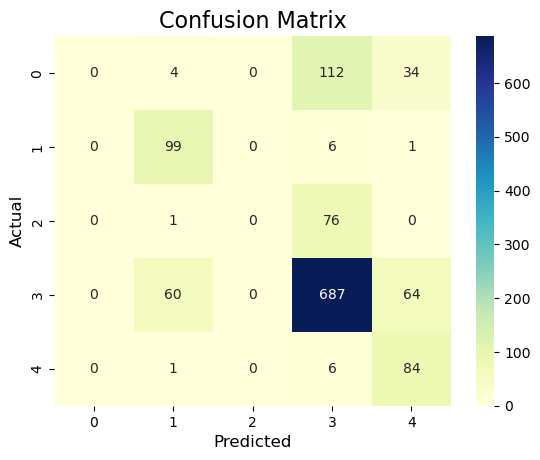

Cross-validation scores: [0.7691373  0.71202916 0.7326853  0.69866343 0.62211422]
Mean cross-validation score: 0.7069258809234508


In [375]:
evaluateModel(lr, lr_y_predictions)

In [381]:
def storeEvaluations(model, y_pred):
    accuracy = accuracy_score(y_test, y_pred) # percentage of y_pred that matches y_test
    precision = precision_score(y_test, y_pred, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
    recall = recall_score(y_test, y_pred, average='micro', zero_division=np.nan)
    f1 = f1_score(y_test, y_pred, average='micro', zero_division=np.nan)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), average='micro', multi_class='ovr')
    df = pd.DataFrame({'Model': model, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 score': f1, 'ROC_AUC': roc_auc}, index=[0])
    return df

In [423]:
modelEvaluations = storeEvaluations(lr, lr_y_predictions)
modelEvaluations_df = pd.concat([modelEvaluations_df, storeEvaluations(dt, dt_y_predictions)])
# modelEvaluations_df = pd.concat([modelEvaluations_df, storeEvaluations(rf, rf_y_predictions)])
modelEvaluations_df

,Model,Accuracy,Precision,Recall,F1 score,ROC_AUC
0,"LogisticRegression(multi_class='ovr', random_s...",0.704453,0.704453,0.704453,0.704453,0.920384
0,DecisionTreeClassifier(random_state=24),0.704453,0.704453,0.704453,0.704453,0.920418
0,DecisionTreeClassifier(random_state=24),0.704453,0.704453,0.704453,0.704453,0.920418
0,DecisionTreeClassifier(random_state=24),0.704453,0.704453,0.704453,0.704453,0.920418
0,DecisionTreeClassifier(random_state=24),0.704453,0.704453,0.704453,0.704453,0.920418


### 2a.) Logistic Regression

In [330]:
# Logistic Regression: create model and predict
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42) # Initialize the model
lr.fit(X_train, y_train['found_code']) # Train the model
lr_y_predictions = lr.predict(X_test) # Make predictions

Accuracy: 0.7044534412955465
Precision: 0.7044534412955465
Recall: 0.7044534412955465
F1-score: 0.7044534412955465
ROC-AUC: 0.9203840416987658
Confusion Matrix:
[[  0   4   0 112  34]
 [  0  99   0   6   1]
 [  0   1   0  76   0]
 [  0  60   0 687  64]
 [  0   1   0   6  84]]


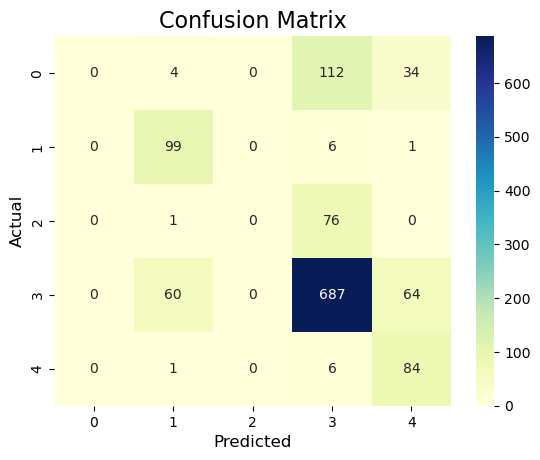

Cross-validation scores: [0.7691373  0.71202916 0.7326853  0.69866343 0.62211422]
Mean cross-validation score: 0.7069258809234508


In [335]:
# Logistic Regression: evaluate model performance
accuracy = accuracy_score(y_test, lr_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, lr_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Confusion Matrix:\n{cm}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(lr, X, y['found_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

### 2b.) Support Vector machine (SVM)

In [339]:
# Support Vector Machine: create model and predict
from sklearn.svm import LinearSVC # Not sure which model to use yet
from sklearn.svm import SVC # Not sure which model to use yet

# svc = LinearSVC() # Create an SVM model
svc = SVC() # Create an SVM model
svc.fit(X_train, y_train['found_code']) # Fit the model to your training data
svc_y_predictions = svc.predict(X_test) # Make predictions

Accuracy: 0.7044534412955465
Precision: 0.7044534412955465
Recall: 0.7044534412955465
F1-score: 0.7044534412955465
ROC-AUC: 0.9203840416987658
Confusion Matrix:
[[  0   4   0 112  34]
 [  0  99   0   6   1]
 [  0   1   0  76   0]
 [  0  60   0 687  64]
 [  0   1   0   6  84]]


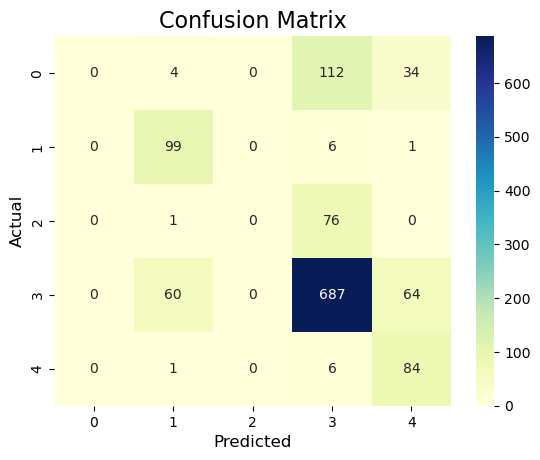

Cross-validation scores: [0.7691373  0.71202916 0.7326853  0.69866343 0.62211422]
Mean cross-validation score: 0.7069258809234508


In [344]:
# Support Vector Machine: evaluate model performance
accuracy = accuracy_score(y_test, svc_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan)
# roc_auc = roc_auc_score(y_test, svc.predict_proba(X_test), average='micro', multi_class='ovr') # Running into error
cm = confusion_matrix(y_test, svc_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Confusion Matrix:\n{cm}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(svc, X, y['found_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

### 2c.) Decision Tree

In [399]:
# Decision Tree: create model and predict
dt = DecisionTreeClassifier(random_state=24) # Initialize the Decision Tree classifier
dt.fit(X_train, y_train) # Train the classifier
dt_y_predictions = dt.predict(X_test) # Make predictions on the test set

Accuracy: 0.7044534412955465
Precision: 0.7044534412955465
Recall: 0.7044534412955465
F1-score: 0.7044534412955465
ROC-AUC: 0.920418135029258
Confusion Matrix:
[[  0   4   0 112  34]
 [  0  99   0   6   1]
 [  0   1   0  76   0]
 [  0  60   0 687  64]
 [  0   1   0   6  84]]


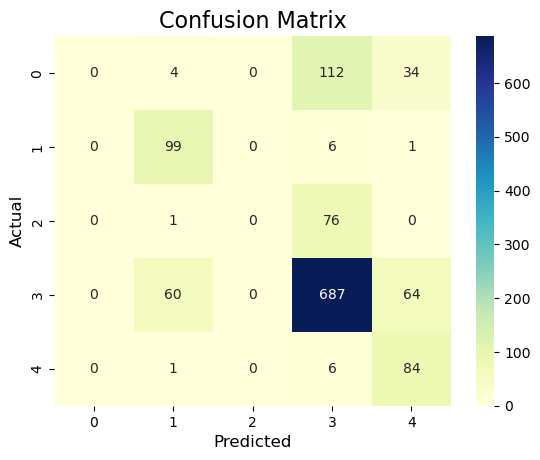

Cross-validation scores: [0.7691373  0.71202916 0.7326853  0.69866343 0.62211422]
Mean cross-validation score: 0.7069258809234508


In [401]:
# Decision Tree: evaluate model performance
accuracy = accuracy_score(y_test, dt_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, dt.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, dt_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Confusion Matrix:\n{cm}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation

from sklearn.model_selection import train_test_split, cross_val_score
cv_scores = cross_val_score(dt, X, y, cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

### 2d.) Random Forest

In [411]:
# Random Forest: create model and predict
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42) # Create a Random Forest classifier
rf.fit(X_train, y_train['found_code']) # Train the classifier on the training data
rf_y_predictions = rf.predict(X_test) # Make predictions on the test data

Accuracy: 0.7044534412955465
Precision: 0.7044534412955465
Recall: 0.7044534412955465
F1-score: 0.7044534412955465
ROC-AUC: 0.920500417971119
Confusion Matrix:
[[  0   4   0 112  34]
 [  0  99   0   6   1]
 [  0   1   0  76   0]
 [  0  60   0 687  64]
 [  0   1   0   6  84]]


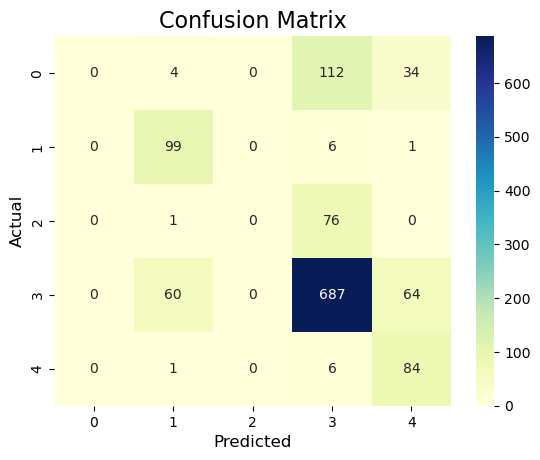

Cross-validation scores: [0.7691373  0.71202916 0.7326853  0.69866343 0.62211422]
Mean cross-validation score: 0.7069258809234508


In [413]:
# Random Forest: evaluate model performance
accuracy = accuracy_score(y_test, rf_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, rf_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Confusion Matrix:\n{cm}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(rf, X, y['found_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

### 2e.) K-Nearest Neighbors

In [419]:
# KNN: create model and predict
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3) # Create a kNN model
knn.fit(X_train, y_train['found_code']) # Fit the model to your training data
knn_y_predictions = knn.predict(X_test) # Make predictions

Accuracy: 0.7044534412955465
Precision: 0.7044534412955465
Recall: 0.7044534412955465
F1-score: 0.7044534412955465
ROC-AUC: 0.8363835663590619
Confusion Matrix:
[[  0   4   0 112  34]
 [  0  99   0   6   1]
 [  0   1   0  76   0]
 [  0  60   0 687  64]
 [  0   1   0   6  84]]


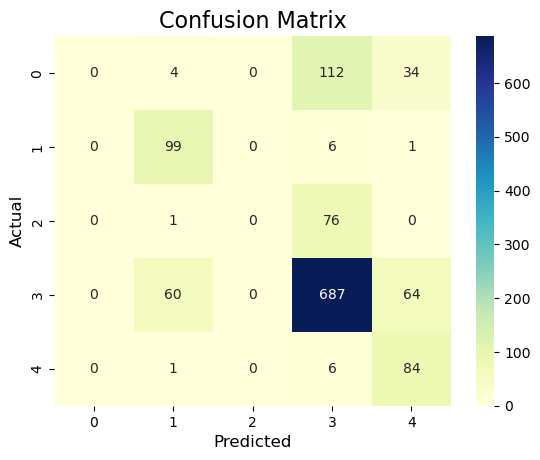

Cross-validation scores: [0.70230863 0.69623329 0.72296476 0.69866343 0.62211422]
Mean cross-validation score: 0.688456865127582


In [421]:
# KNN: evaluate model performance
accuracy = accuracy_score(y_test, knn_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, knn_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Confusion Matrix:\n{cm}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# KNN: cross-validation
cv_scores = cross_val_score(knn, X, y['found_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

## 3.) Model Evaluation and Metrics [dogTravel]

In [441]:
def EvalMetrics(model, accuracy, precision, recall, f1, roc_auc, cv_score):
    df = pd.DataFrame({'Model': model, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 score': f1, 'ROC_AUC': roc_auc, 'mean CV score': cv_score}, index=[0])
    return df

lr_df = EvalMetrics('Logistic Regression', 0.70445, 0.70445, 0.70445, 0.70445, 0.92038, 0.70693)
svm_df = EvalMetrics('Support Vector Machine', 0.70445, 0.70445, 0.70445, 0.70445, 0.92038, 0.70693)
dt_df = EvalMetrics('Decision Tree', 0.70445, 0.70445, 0.70445, 0.70445, 0.92042, 0.70693)
rf_df = EvalMetrics('Random Forest', 0.70445, 0.70445, 0.70445, 0.70445, 0.92050, 0.70693)
knn_df = EvalMetrics('K-Nearest Neighbors', 0.70445, 0.70445, 0.70445, 0.70445, 0.83638, 0.68846)
evaluationMetrics_df = pd.concat([lr_df, svm_df, dt_df, rf_df, knn_df], ignore_index=True)
evaluationMetrics_df

,Model,Accuracy,Precision,Recall,F1 score,ROC_AUC,mean CV score
0,Logistic Regression,0.70445,0.70445,0.70445,0.70445,0.92038,0.70693
1,Support Vector Machine,0.70445,0.70445,0.70445,0.70445,0.92038,0.70693
2,Decision Tree,0.70445,0.70445,0.70445,0.70445,0.92042,0.70693
3,Random Forest,0.70445,0.70445,0.70445,0.70445,0.92050,0.70693
4,K-Nearest Neighbors,0.70445,0.70445,0.70445,0.70445,0.83638,0.68846


## 4.) Making models and evaluating them [allDogs]

In [ ]:
# Split data into training and test sets
X = allDogs_encoded.drop('breed_code', axis=1)
y = allDogs_encoded[['breed_code']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Accuracy: 0.4188034188034188
Precision: 0.4188034188034188
Recall: 0.4188034188034188
F1-score: 0.4188034188034188
ROC-AUC: 0.8498128230540376


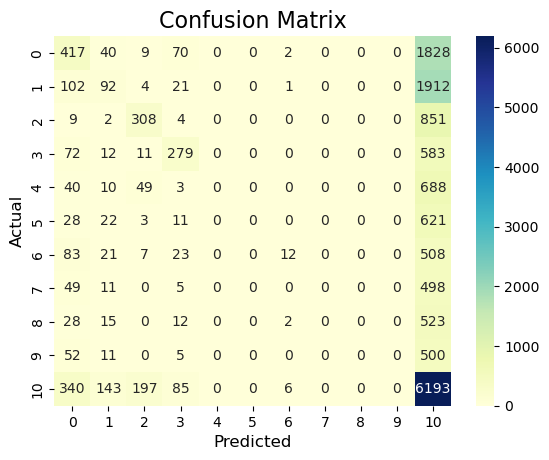

Cross-validation scores: [0.29951816 0.32688006 0.25159181 0.25135531 0.34687204]
Mean cross-validation score: 0.2952434731947521


,Model,Accuracy,Precision,Recall,F1 score,ROC_AUC,mean CV score
0,Logistic Regression,0.418803,0.418803,0.418803,0.418803,0.849813,0.295243


In [477]:
# Logistic Regression
lr = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42) # Initialize the model
lr.fit(X_train, y_train['breed_code']) # Train the model
lr_y_predictions = lr.predict(X_test) # Make predictions

# Logistic Regression: evaluate model performance
accuracy = accuracy_score(y_test, lr_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, lr_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(range(11)), yticklabels=list(range(11)))
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(lr, X, y['breed_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

lr_df = EvalMetrics('Logistic Regression', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())
lr_df

In [492]:
# # Support Vector Machine
# # svc = LinearSVC() # Create an SVM model
# svc = SVC() # Create an SVM model
# svc.fit(X_train, y_train['breed_code']) # Fit the model to your training data
# svc_y_predictions = svc.predict(X_test) # Make predictions

# # Support Vector Machine: evaluate model performance
# accuracy = accuracy_score(y_test, svc_y_predictions) # percentage of y_pred that matches y_test
# precision = precision_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
# recall = recall_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan)
# f1 = f1_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan)
# # roc_auc = roc_auc_score(y_test, svc.predict_proba(X_test), average='micro', multi_class='ovr') # Running into error
# cm = confusion_matrix(y_test, svc_y_predictions)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1-score: {f1}")
# print(f"ROC-AUC: {roc_auc}")

# # Plot the confusion matrix
# sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(range(11)), yticklabels=list(range(11)))
# plt.xlabel('Predicted', fontsize=12)
# plt.ylabel('Actual', fontsize=12)
# plt.title('Confusion Matrix',fontsize=16)
# plt.show()

# # Cross-validation
# cv_scores = cross_val_score(svc, X, y['breed_code'], cv=5) # 5-fold cross-validation
# print(f"Cross-validation scores: {cv_scores}")
# print(f"Mean cross-validation score: {cv_scores.mean()}")

# svm_df = EvalMetrics('Support Vector Machine', accuracy, precision, recall, f1, np.nan, cv_scores.mean())
# svm_df

Accuracy: 0.3892043824929731
Precision: 0.3892043824929731
Recall: 0.3892043824929731
F1-score: 0.3892043824929731
ROC-AUC: 0.7481914251779087


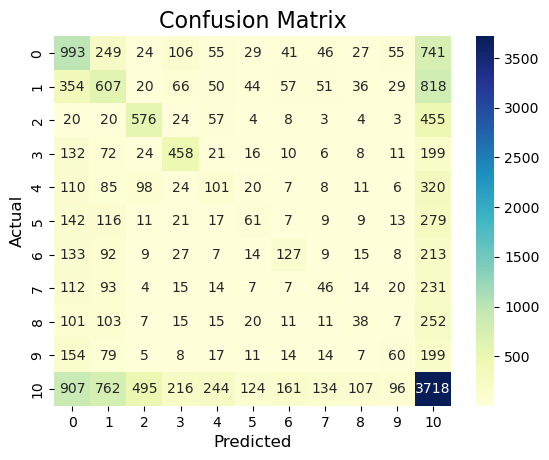

Cross-validation scores: [0.27103769 0.26725176 0.26191705 0.25307633 0.28732467]
Mean cross-validation score: 0.26812150061948364


,Model,Accuracy,Precision,Recall,F1 score,ROC_AUC,mean CV score
0,Decision Tree,0.389204,0.389204,0.389204,0.389204,0.748191,0.268122


In [481]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=24) # Initialize the Decision Tree classifier
dt.fit(X_train, y_train) # Train the classifier
dt_y_predictions = dt.predict(X_test) # Make predictions on the test set

# Decision Tree: evaluate model performance
accuracy = accuracy_score(y_test, dt_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, dt.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, dt_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(range(11)), yticklabels=list(range(11)))
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(dt, X, y, cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")
dt_df = EvalMetrics('Decision Tree', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())
dt_df

Accuracy: 0.4186886938564791
Precision: 0.4186886938564791
Recall: 0.4186886938564791
F1-score: 0.4186886938564791
ROC-AUC: 0.8236179693619241


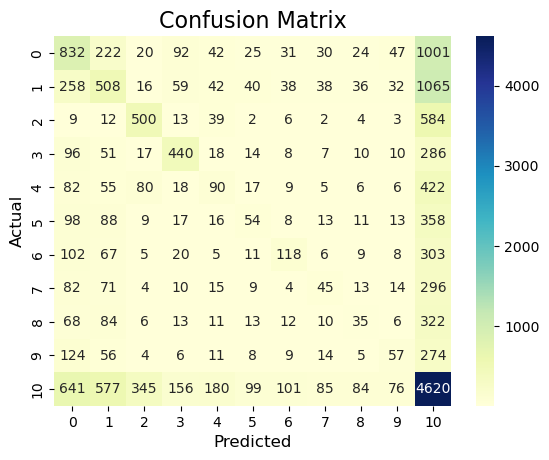

Cross-validation scores: [0.3037343  0.2996042  0.29194631 0.29446691 0.33723432]
Mean cross-validation score: 0.30539720704234263


,Model,Accuracy,Precision,Recall,F1 score,ROC_AUC,mean CV score
0,Random Forest,0.418689,0.418689,0.418689,0.418689,0.823618,0.305397


In [485]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42) # Create a Random Forest classifier
rf.fit(X_train, y_train['breed_code']) # Train the classifier on the training data
rf_y_predictions = rf.predict(X_test) # Make predictions on the test data

# Random Forest: evaluate model performance
accuracy = accuracy_score(y_test, rf_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, rf_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(range(11)), yticklabels=list(range(11)))
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(rf, X, y['breed_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")
rf_df = EvalMetrics('Random Forest', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())
rf_df

Accuracy: 0.3512304250559284
Precision: 0.3512304250559284
Recall: 0.3512304250559284
F1-score: 0.3512304250559284
ROC-AUC: 0.7301765796460536


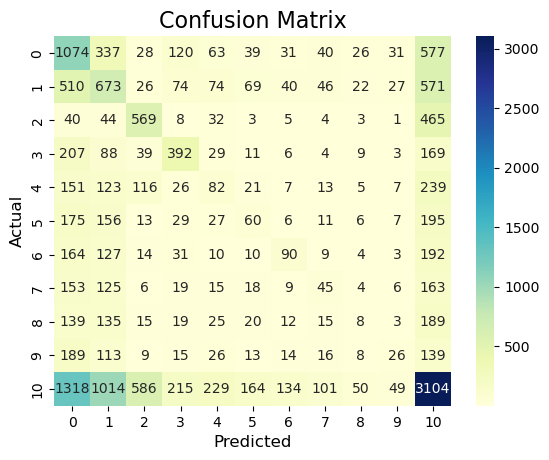

Cross-validation scores: [0.21416279 0.23102736 0.25554982 0.24378281 0.25789519]
Mean cross-validation score: 0.24048359452756377


,Model,Accuracy,Precision,Recall,F1 score,ROC_AUC,mean CV score
0,K-Nearest Neighbors,0.35123,0.35123,0.35123,0.35123,0.730177,0.240484


In [487]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3) # Create a kNN model
knn.fit(X_train, y_train['breed_code']) # Fit the model to your training data
knn_y_predictions = knn.predict(X_test) # Make predictions

# KNN: evaluate model performance
accuracy = accuracy_score(y_test, knn_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, knn_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(range(11)), yticklabels=list(range(11)))
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(knn, X, y['breed_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")
knn_df = EvalMetrics('K-Nearest Neighbors', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())
knn_df

In [489]:
allDogs_evaluationMetrics_df = pd.concat([lr_df, dt_df, rf_df, knn_df], ignore_index=True)
allDogs_evaluationMetrics_df

,Model,Accuracy,Precision,Recall,F1 score,ROC_AUC,mean CV score
0,Logistic Regression,0.418803,0.418803,0.418803,0.418803,0.849813,0.295243
1,Decision Tree,0.389204,0.389204,0.389204,0.389204,0.748191,0.268122
2,Random Forest,0.418689,0.418689,0.418689,0.418689,0.823618,0.305397
3,K-Nearest Neighbors,0.351230,0.351230,0.351230,0.351230,0.730177,0.240484


# 5.) Conlcusion